<a href="https://colab.research.google.com/github/Viktor2k/playground/blob/master/Dog_face_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
files = ['/content/gdrive/MyDrive/Projects/PaiNT/good_dataset/img_10.jpg', '/content/gdrive/MyDrive/Projects/PaiNT/good_dataset/img_100.jpg', '/content/gdrive/MyDrive/Projects/PaiNT/good_dataset/img_1006.jpg']
with open('/content/file-list.txt', 'w') as f:
    for file in files:
        f.write(file+'\n')

In [ ]:
%%writefile /content/requirements.txt
cv2
tqdm
dlib
numpy
click
pandas
matplotlib

In [74]:
%%writefile /content/detect_faces_and_calculate_features.py
import os
import cv2
import dlib
import click
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import atan
from tqdm import tqdm
from imutils import face_utils
from datetime import datetime


detector = dlib.cnn_face_detection_model_v1('dogHeadDetector.dat')
predictor = dlib.shape_predictor('landmarkDetector.dat')


@click.command()
@click.option("--file-list", required=True, help="Path to txt file containing paths to all images you want to process")
def main(file_list):
    # Read input file list
    with open(file_list) as f:
        files = [r.strip() for r in f]
    
    # Detect doggos and doggo-face-features
    valid_results = []
    invalid_results = []
    for img_path in tqdm(files):
        try:
            (_, bounding_boxes, features, directions, tilts) = dog_detector(img_path)
            
            # Not ok to have more than one doggo per image. 
            if len(directions) != 1 or len(tilts) != 1:
                invalid_results.append([img_path, bounding_boxes, features, directions, tilts])
                continue

            valid_results.append([img_path, bounding_boxes, features, directions[0], tilts[0]])    

        except Exception as e:
            print(f'File {img_path} failed to process with reason:\n' + str(e))
    
    # Create output directory
    now = datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(now)

    # Save valid results
    for out_name, results in [('valid_dog_face_detection.csv', valid_results), ('invalid_dog_face_detection.csv', invalid_results)]:
        df = pd.DataFrame.from_records(results)
        if len(df) > 0:
            df.columns = ['file', 'bounding_box', 'face_features', 'direction', 'tilt']
            df.to_csv(os.path.join(now, out_name))



def dog_detector(img_path, out_path=None, save=False):
    # Read image
    img_name = os.path.basename(img_path)
    filename, ext = os.path.splitext(img_name)
    img = cv2.imread(img_path)

    # Detect faces
    face_detections = detector(img, upsample_num_times=2)
    bounding_boxes = []
    for i, d in enumerate(face_detections):
        x1, y1 = d.rect.left(), d.rect.top()
        x2, y2 = d.rect.right(), d.rect.bottom()
        bounding_boxes.append({'top_left': (x1, y1), 'bottom_right': (x2, y2), 'confidence': d.confidence})

    # Detect features in faces
    face_features = []
    for i, d in enumerate(face_detections):
        features = predictor(img, d.rect)
        features = face_utils.shape_to_np(features)
        face_features.append(features)

    # Calculate face metrics
    directions = [direction(feature) for feature in face_features]
    tilts = [tilt(feature) for feature in face_features]

    # Save result per image
    if save:
        img_result = img.copy()

        # Draw bounding box
        for box in bounding_boxes:
            x1, y1 = box.get('top_left')
            x2, y2 = box.get('bottom_right')
            cv2.rectangle(img_result, pt1=(x1, y1), pt2=(x2, y2), thickness=2, color=(255,0,0), lineType=cv2.LINE_AA)
    
        # Draw face feature points
        for features in face_features:
            for i, p in enumerate(features):
                cv2.circle(img_result, center=tuple(p), radius=3, color=(0,0,255), thickness=-1, lineType=cv2.LINE_AA)
                cv2.putText(img_result, str(i), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
        
        cv2.imwrite(os.path.join(out_path, img_name), img_result)

        # Save data
        with open(os.path.join(out_path, f'{filename}.pkl'), 'wb') as f:
            pickle.dump([bounding_boxes, face_features], f)

        plt.figure(figsize=(16, 16))
        plt.imshow(img_result)
    
    return [img_path, bounding_boxes, face_features, directions, tilts]


def direction(shapes):
    # Returns value indicating direction of head. 
    # Positive output indicates head is pointing to right
    # Negavitve output indicates head is pointint to left
    # Zero indicates straight on
    
    ## Indices in shapes list
    # 5 is eye on the left of image
    # 2 is eye on the right of image
    # 3 is nose
    
    eye_midpoint_x = (shapes[5][0] + shapes[2][0]) / 2
    eye_distance = abs(shapes[5][0] - shapes[2][0])
    
    nose_x = shapes[3][0]
    return (nose_x-eye_midpoint_x)/eye_distance

def tilt(shapes):
    # Returns the angle between the horisontal and line between eyes in radians
    # Positive value indicates head tilted to the left
    # Negative value inidicates head tilted to the right
    
    eye_vertical_distance = abs(shapes[5][0] - shapes[2][0])
    eye_horizontal_distance = shapes[5][1] - shapes[2][1]
    
    return atan(eye_horizontal_distance/eye_vertical_distance)
    
if __name__ == "__main__":
    main()

Overwriting /content/detect_faces_and_calculate_features.py


In [73]:
%cd /content
!python -m detect_faces_and_calculate_features --file-list='file-list.txt'

/content
100% 3/3 [00:01<00:00,  1.58it/s]


In [114]:
%%writefile /content/pose_filter.py
import os
import click
import pandas as pd

class CommaSeparatedFloatList(click.ParamType):
    name = 'list'
    def convert(self, value, param, ctx):
        _ = param, ctx
        if value is None:
            return []
        return [float(v) for v in value.split(',')]

@click.command()
@click.option("--input-csv", type=click.Path(), required=True, help='Path to csv file generated by detect_faces_and_calculate_features.py')
@click.option("--valid-directions", "-d", type=CommaSeparatedFloatList(), required=True, default='-0.5,0.5', help="Min and max values for doggo direction.")
@click.option("--valid-tilts", "-t", type=CommaSeparatedFloatList(), required=True, default='-0.1,0.1', help="Min and max values for doggo direction.")
def main(input_csv, valid_directions, valid_tilts):
    min_dir = min(valid_directions)
    max_dir = max(valid_directions)

    min_tilt = min(valid_tilts)
    max_tilt = max(valid_tilts)

    def is_valid_direction(direction):
        return min_dir <= direction <= max_dir
    
    def is_valid_tilt(tilt):
        return min_tilt <= tilt <= max_tilt

    def is_valid(row):
        return is_valid_direction(row.direction) and is_valid_tilt(row.tilt)

    df = pd.read_csv(input_csv)
    df['is_valid'] = df.apply(lambda row: is_valid(row), axis=1)
    valid_files = list(df[df.is_valid]['file'])
    invalid_files = list(df[~df.is_valid]['file'])
    
    out_dir = os.path.dirname(input_csv)
    file_suffix = f'dog_face_pose-dir({min_dir},{max_dir})-tilt({min_tilt},{max_tilt})'
    
    for file_list, file_prefix in [(valid_files, 'valid'), (invalid_files, 'invalid')]:
        with open(os.path.join(out_dir, f'{file_prefix}_{file_suffix}'), 'w') as out:
            [out.write(f + '\n') for f in file_list]

if __name__ == '__main__':
    main()


Overwriting /content/pose_filter.py


In [115]:
!python pose_filter.py --input-csv /content/20210418-113657/valid_dog_face_detection.csv -d -1,2 -t -0.4,0.3

In [122]:
%%writefile /content/image_utils.py
import os

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid


def show_grid(image_paths, grid_dims=(5,15)):
    fig = plt.figure(figsize=(25., 75.))
    grid = ImageGrid(fig, 111, nrows_ncols=grid_dims, axes_pad=0.1)

    for ax, im in zip(grid, [square_image(p) for p in image_paths[:grid_dims[0]*grid_dims[1]]]):
        ax.imshow(im)

    plt.show()
    return fig
    

def square_image(im_pth, desired_size=256):
    im = Image.open(im_pth)
    old_size = im.size  

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = im.resize(new_size, Image.ANTIALIAS)

    new_im = Image.new("RGB", (desired_size, desired_size), "white")
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))
    return new_im

    

Writing /content/image_utils.py


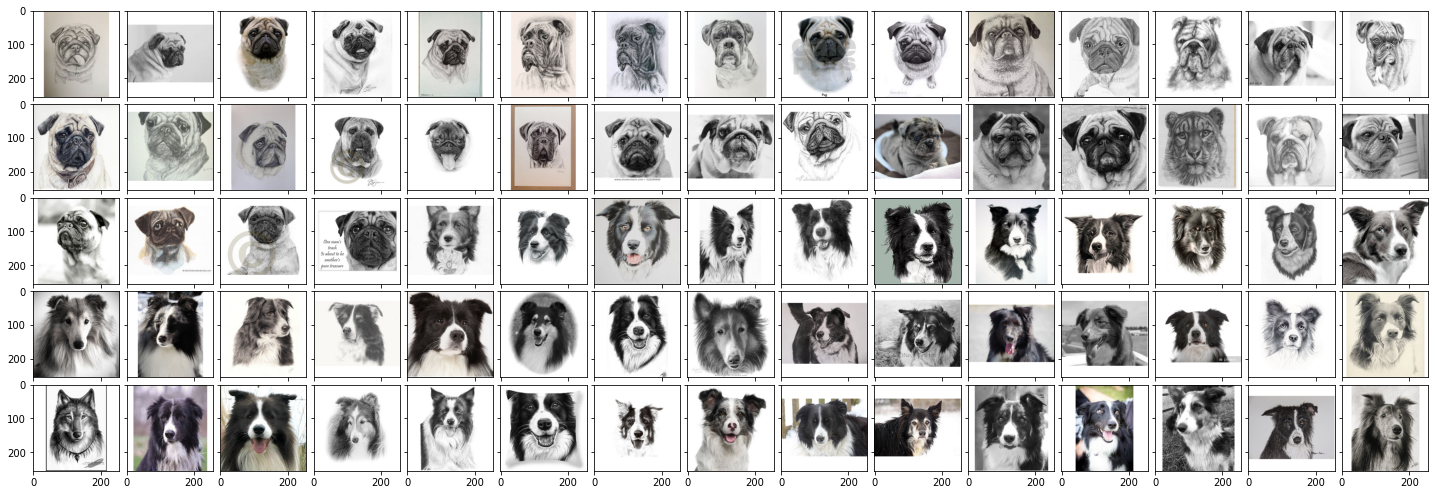

In [ ]:
img = show_grid([os.path.join(dir_path, img) for img in list(straight_no_tilt.img_name)])
#show_grid([os.path.join(dir_path, img) for img in list(no_straight_or_tilt.img_name)])
#show_grid([os.path.join(dir_path, img) for img in list(right_no_tilt.img_name)])
#show_grid([os.path.join(dir_path, img) for img in list(left_no_tilt.img_name)])

In [ ]:
fig.savefig('grid.jpeg')